In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.svm import SVR
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from hyperopt import fmin,tpe,hp,Trials
from hyperopt.pyll.stochastic import sample
import random

In [2]:
cuo_water_data=pd.read_excel("Mech Project.xlsx").astype("float64")
cuo_water_data.head()

,Temperature,Nanparticle Heat Capacity,Volume fraction,CuO/water heat capacity
0,298.31,0.536,0.4,4.082
1,300.32,0.535,0.4,4.081
2,302.35,0.533,0.4,4.079
3,304.36,0.538,0.4,4.082
4,306.37,0.548,0.4,4.085


In [374]:
cuo_water_data.corr(method="pearson")

,Temperature,Nanparticle Heat Capacity,Volume fraction,CuO/water heat capacity
Temperature,1.000000,9.859940e-01,-2.395325e-04,0.036872
Nanparticle Heat Capacity,0.985994,1.000000e+00,1.110806e-14,0.036781
Volume fraction,-0.000240,1.110806e-14,1.000000e+00,-0.999136
CuO/water heat capacity,0.036872,3.678085e-02,-9.991359e-01,1.000000


In [403]:
X=cuo_water_data[cuo_water_data.columns[0:3]]
y=cuo_water_data[cuo_water_data.columns[3]]

In [376]:
y=y.reshape(-1,1)

In [377]:
sc_X=preprocessing.MinMaxScaler()
sc_y=preprocessing.MinMaxScaler()
X=sc_X.fit_transform(X)
y=sc_y.fit_transform(y)

In [378]:
X.shape

(105, 3)

In [379]:
y.shape

(105, 1)

In [380]:
random_state=45
num_folds=10

kf=KFold(n_splits=num_folds,random_state=random_state,shuffle=True)

In [381]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)

In [382]:
def objective(params, cv=kf, X=X_train, y=y_train):

    params = {'kernel': params['kernel'],
              'C': params['C'],
              'epsilon': params['epsilon']}

    model = SVR(**params)

    score = -cross_val_score(model, X, y, cv=cv,
                             scoring='neg_mean_squared_error', n_jobs=-1).mean()

    return score


In [383]:
space = {
    'kernel': hp.choice('kernel', ['linear','rbf','sigmoid','poly']),
    'C': hp.quniform('C', 0.005, 500, 0.01),
    'epsilon': hp.uniform('epsilon', 0, 1),
}

In [384]:
kernel_dict={
    0:'linear',
    1:'rbf',
    2:'sigmoid',
    3:'poly'
}

In [385]:
MAX_EVALS=50

In [5]:
%%time

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=MAX_EVALS, rstate=np.random.default_rng(random_state),trials=trials)


NameError: name 'objective' is not defined

In [387]:
best

{'C': 194.51, 'epsilon': 0.005217629802907759, 'kernel': 0}

In [388]:
model = SVR(epsilon=best['epsilon'], C=best['C'], kernel=kernel_dict[best['kernel']])
model.fit(X_train, y_train)

C:\Users\aritr\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=194.51, epsilon=0.005217629802907759, kernel='linear')

In [389]:
tpe_test_score = mean_squared_error(y_test, model.predict(X_test))

print("Best MSE: ", trials.best_trial['result']['loss'])


Best MSE:  4.3419856652538686e-05


In [390]:
tpe_test_score

6.363931648183716e-05

In [391]:
y_pred=model.predict(X_test)
y_pred.shape

(21,)

In [392]:
y_pred=y_pred.reshape(-1,1)

In [393]:
y_pred=sc_y.inverse_transform(y_pred)

In [394]:
y_test=sc_y.inverse_transform(y_test)

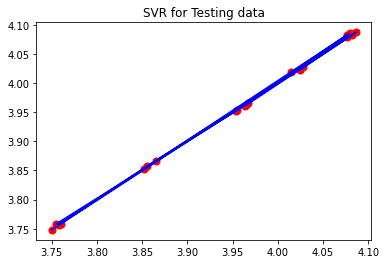

In [395]:
plt.scatter(y_pred,y_test,s=50,c="red")
plt.plot(y_pred,y_test,c="blue")
plt.title("SVR for Testing data")
plt.show()

In [396]:
y_train_pred=model.predict(X_train)
y_train_pred=sc_y.inverse_transform(y_train_pred.reshape(-1,1))

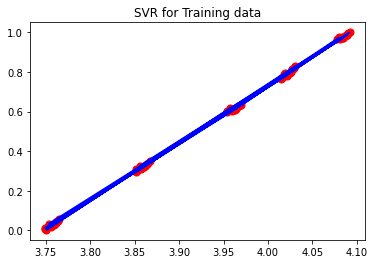

In [397]:
plt.scatter(y_train_pred,y_train,s=50,c="red")
plt.plot(y_train_pred,y_train,c="blue")
plt.title("SVR for Training data")
plt.show()

<h1>ANN</h1>

In [3]:
import tensorflow as tf
import levenberg_marquardt as lm
import warnings
warnings.filterwarnings("ignore")

random_state=87

In [4]:
X=cuo_water_data[cuo_water_data.columns[0:3]]
y=cuo_water_data[cuo_water_data.columns[3]].values

In [5]:
X[X.isnull() == True]

,Temperature,Nanparticle Heat Capacity,Volume fraction
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
100,NaN,NaN,NaN
101,NaN,NaN,NaN
102,NaN,NaN,NaN
103,NaN,NaN,NaN


In [6]:
y=y.reshape(-1,1)

In [7]:
sc_X=preprocessing.MinMaxScaler()
sc_y=preprocessing.MinMaxScaler()
X=sc_X.fit_transform(X)
y=sc_y.fit_transform(y)

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=random_state)

In [9]:
from keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam,Ftrl

In [10]:
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=0.1)

In [30]:
def objective_ann(params,X_train=X_train,y_train=y_train):
    learning_rate=params['learning_rate']
    
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta',
                'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    
    optimizerD = {'Adam': Adam(lr=learning_rate), 'SGD': SGD(lr=learning_rate),
                'RMSprop': RMSprop(lr=learning_rate), 'Adadelta': Adadelta(lr=learning_rate),
                'Adagrad': Adagrad(lr=learning_rate), 'Adamax': Adamax(lr=learning_rate),
                'Nadam': Nadam(lr=learning_rate), 'Ftrl': Ftrl(lr=learning_rate)}
    
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                'elu', 'exponential', LeakyReLU, 'relu']

    nodes=(int)(params['nodes'])
    opt=optimizerL[params['optimizer']]
    opt=optimizerD[opt]
    activation=activationL[params['activation']]
    batch_size=(int)(params['batch_size'])
    epochs=(int)(params['epochs'])
    #num_hidden_layers=(int)(params['num_hidden_layers'])
    num_hidden_layers=1
    
    def get_model():    
        model=tf.keras.models.Sequential()
         
        model.add(tf.keras.layers.Dense(nodes,input_dim=X_train.shape[1],activation=activation))
        model.add(tf.keras.layers.Dropout(rate=params['dropout_prob']))             
            
        for i in range(num_hidden_layers-1):
            model.add(tf.keras.layers.Dense(nodes,activation=activation))
            model.add(tf.keras.layers.Dropout(rate=params['dropout_prob']))       
        
        model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
        model.add(tf.keras.layers.Dropout(rate=params['dropout_prob']))
        
        model.compile(loss=tf.keras.losses.mean_squared_error,optimizer=opt,metrics=['mse'])
        return model

    es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='max',verbose=0,patience=20)
    nn=tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_model,epochs=epochs,batch_size=batch_size,verbose=0)
    
    
    kfold=KFold(n_splits=10,shuffle=True,random_state=random_state)
    score=-cross_val_score(nn,X_train,y_train,error_score='raise',scoring='neg_mean_squared_error',cv=kfold,fit_params={'callbacks':[es]},n_jobs=-1).mean()
    
    return score

In [16]:
from hyperopt.pyll.base import scope

In [22]:
ann_params_space={
    'activation':hp.choice('activation',[0,1,2,3,4,5,6,7,8,9]),
    'optimizer':hp.choice('optimizer',[0,1,2,3,4,5,6,7]),
    'num_hidden_layers':hp.quniform('num_hidden_layers',1,6,1),
    'nodes':scope.int(hp.quniform('nodes',1,200,1)),
    'dropout_prob':hp.uniform('dropout_prob',0,1),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.001),np.log(0.2)), 
    'batch_size':hp.quniform('batch_size',1, 100,1),
    'epochs':hp.quniform('epochs',10, 500,10)
}

In [31]:
ann_trials=Trials()

best=fmin(fn=objective_ann,space=ann_params_space,algo=tpe.suggest,max_evals=500,rstate=np.random.default_rng(random_state),trials=ann_trials)

  1%|          | 6/500 [01:06<1:31:36, 11.13s/trial, best loss: 0.09873961390119983]


KeyboardInterrupt: 

In [ ]:
(ann_trials.trials)

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 0.26224127026788635, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'activation': [0],
    'batch_size': [0],
    'dropout_prob': [0],
    'epochs': [0],
    'learning_rate': [0],
    'nodes': [0],
    'num_hidden_layers': [0],
    'optimizer': [0]},
   'vals': {'activation': [7],
    'batch_size': [58.0],
    'dropout_prob': [0.6807824657058615],
    'epochs': [200.0],
    'learning_rate': [0.004967944759844677],
    'nodes': [159.0],
    'num_hidden_layers': [2.0],
    'optimizer': [6]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 3, 7, 13, 7, 22, 63000),
  'refresh_time': datetime.datetime(2023, 3, 7, 13, 7, 44, 431000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 0.11406292818860975, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'wor

In [ ]:
best

NameError: name 'best' is not defined

In [ ]:
test_loss=objective_ann(best,X_train=X_test,y_train=y_test)

KeyError: 'learning_rate'